In [0]:
#


In [0]:
#!for f in TRAIN/*; do [ -d ./"$f" ] && find ./"$f" -maxdepth 1 -exec echo \; | wc -l && echo $f; done



In [6]:
import numpy as np
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from keras.preprocessing.image import load_img

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from PIL import Image

from skimage import color, io
from scipy.misc import imresize
from keras.utils import to_categorical

from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Tomato/segmented/pringles')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cp

TEST  TRAIN


In [0]:
#!ls /content/drive/My\ Drive/Colab\ Notebooks/Tomato/segmented/TRAIN

In [0]:
!for f in TEST/*; do [ -d ./"$f" ] && find ./"$f" -maxdepth 1 -exec echo \; | wc -l && echo "$f"; done 

305
TEST/Bacterial_Spot
301
TEST/Early_Blight
301
TEST/Healthy
301
TEST/Late_Blight
301
TEST/NAGALI
302
TEST/Septoria_Leaf_Spot


In [0]:
!for f in TRAIN/*; do [ -d ./"$f" ] && find ./"$f" -maxdepth 1 -exec echo \; | wc -l && echo $f; done


901
TRAIN/Bacterial_Spot
923
TRAIN/Early_Blight
901
TRAIN/Healthy
901
TRAIN/Late_Blight
901
TRAIN/NAGALI
912
TRAIN/Septoria_Leaf_Spot


In [0]:
from keras import backend as K
K.image_data_format()

'channels_last'

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 256, 256
train_data_dir = "./TRAIN"
validation_data_dir = "./TEST"
nb_train_samples = 5439
nb_validation_samples = 1812 
batch_size = 32
epochs = 25

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))


# Freeze the layers which you don't want to train. Here I am freezing the first 12 layers.
# for layer in model.layers[:15]:
#     layer.trainable = False






Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
!pip install livelossplot

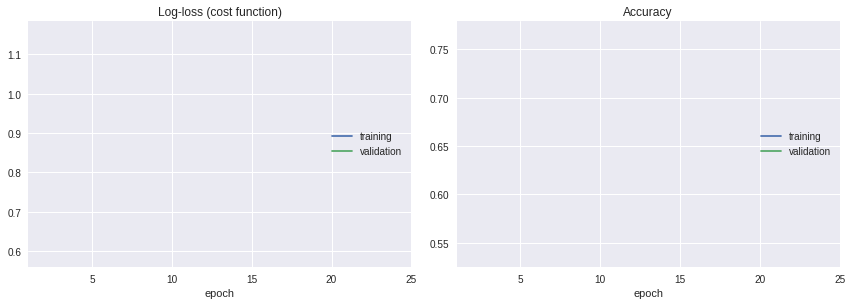

Log-loss (cost function):
training   (min:    1.155, max:    1.155, cur:    1.155)
validation (min:    0.589, max:    0.589, cur:    0.589)

Accuracy:
training   (min:    0.537, max:    0.537, cur:    0.537)
validation (min:    0.767, max:    0.767, cur:    0.767)

Epoch 00001: val_acc improved from -inf to 0.76738, saving model to vgg1922.h5
Epoch 2/25
168/169 [============================>.] - ETA: 0s - loss: 0.4826 - acc: 0.8177

In [0]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(6, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

for layer in model_final.layers[:10]:
    layer.trainable = False

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9), metrics=["accuracy"])

# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=20)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=20)
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")



# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg1922.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

from livelossplot import PlotLossesKeras

# Train the model 
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [PlotLossesKeras(),checkpoint, early])

In [0]:
'''/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':
Found 5068 images belonging to 4 classes.
Found 920 images belonging to 4 classes.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=257, validation_steps=466)`
Epoch 1/50
257/257 [==============================] - 1767s 7s/step - loss: 1.1067 - acc: 0.5173 - val_loss: 0.7739 - val_acc: 0.6597

Epoch 00001: val_acc improved from -inf to 0.65970, saving model to vgg16_1.h5
Epoch 2/50
257/257 [==============================] - 627s 2s/step - loss: 0.7370 - acc: 0.6980 - val_loss: 0.4565 - val_acc: 0.8285

Epoch 00002: val_acc improved from 0.65970 to 0.82846, saving model to vgg16_1.h5
Epoch 3/50
257/257 [==============================] - 433s 2s/step - loss: 0.5046 - acc: 0.8108 - val_loss: 0.4036 - val_acc: 0.8487

Epoch 00003: val_acc improved from 0.82846 to 0.84869, saving model to vgg16_1.h5
Epoch 4/50
257/257 [==============================] - 430s 2s/step - loss: 0.3700 - acc: 0.8560 - val_loss: 0.2265 - val_acc: 0.9197

Epoch 00004: val_acc improved from 0.84869 to 0.91971, saving model to vgg16_1.h5
Epoch 5/50
257/257 [==============================] - 430s 2s/step - loss: 0.3120 - acc: 0.8816 - val_loss: 0.1743 - val_acc: 0.9395

Epoch 00005: val_acc improved from 0.91971 to 0.93953, saving model to vgg16_1.h5
Epoch 6/50
257/257 [==============================] - 436s 2s/step - loss: 0.2675 - acc: 0.9049 - val_loss: 0.1674 - val_acc: 0.9420

Epoch 00006: val_acc improved from 0.93953 to 0.94203, saving model to vgg16_1.h5
Epoch 7/50
257/257 [==============================] - 450s 2s/step - loss: 0.2187 - acc: 0.9214 - val_loss: 0.4863 - val_acc: 0.8427

Epoch 00007: val_acc did not improve from 0.94203
Epoch 8/50
257/257 [==============================] - 432s 2s/step - loss: 0.2176 - acc: 0.9271 - val_loss: 0.1359 - val_acc: 0.9535

Epoch 00008: val_acc improved from 0.94203 to 0.95353, saving model to vgg16_1.h5
Epoch 9/50
257/257 [==============================] - 447s 2s/step - loss: 0.1780 - acc: 0.9386 - val_loss: 0.2940 - val_acc: 0.8985

Epoch 00009: val_acc did not improve from 0.95353
Epoch 10/50
257/257 [==============================] - 450s 2s/step - loss: 0.1587 - acc: 0.9467 - val_loss: 0.1846 - val_acc: 0.9363

Epoch 00010: val_acc did not improve from 0.95353
Epoch 11/50
257/257 [==============================] - 443s 2s/step - loss: 0.1594 - acc: 0.9453 - val_loss: 0.0992 - val_acc: 0.9652

Epoch 00011: val_acc improved from 0.95353 to 0.96517, saving model to vgg16_1.h5
Epoch 12/50
257/257 [==============================] - 451s 2s/step - loss: 0.1460 - acc: 0.9480 - val_loss: 0.1224 - val_acc: 0.9600

Epoch 00012: val_acc did not improve from 0.96517
Epoch 13/50
257/257 [==============================] - 440s 2s/step - loss: 0.1227 - acc: 0.9601 - val_loss: 0.0928 - val_acc: 0.9678

Epoch 00013: val_acc improved from 0.96517 to 0.96780, saving model to vgg16_1.h5
Epoch 14/50
257/257 [==============================] - 433s 2s/step - loss: 0.1325 - acc: 0.9531 - val_loss: 0.1164 - val_acc: 0.9605

Epoch 00014: val_acc did not improve from 0.96780
Epoch 15/50
257/257 [==============================] - 430s 2s/step - loss: 0.1063 - acc: 0.9621 - val_loss: 0.1227 - val_acc: 0.9604

Epoch 00015: val_acc did not improve from 0.96780
Epoch 16/50
257/257 [==============================] - 437s 2s/step - loss: 0.1158 - acc: 0.9599 - val_loss: 0.1280 - val_acc: 0.9572

Epoch 00016: val_acc did not improve from 0.96780
Epoch 17/50
257/257 [==============================] - 434s 2s/step - loss: 0.1005 - acc: 0.9691 - val_loss: 0.0948 - val_acc: 0.9687

Epoch 00017: val_acc improved from 0.96780 to 0.96868, saving model to vgg16_1.h5
Epoch 18/50
257/257 [==============================] - 433s 2s/step - loss: 0.1026 - acc: 0.9635 - val_loss: 0.1100 - val_acc: 0.9621

Epoch 00018: val_acc did not improve from 0.96868
Epoch 19/50
257/257 [==============================] - 435s 2s/step - loss: 0.0914 - acc: 0.9696 - val_loss: 0.1361 - val_acc: 0.9531

Epoch 00019: val_acc did not improve from 0.96868
Epoch 20/50
257/257 [==============================] - 426s 2s/step - loss: 0.0949 - acc: 0.9673 - val_loss: 0.0782 - val_acc: 0.9759

Epoch 00020: val_acc improved from 0.96868 to 0.97592, saving model to vgg16_1.h5
Epoch 21/50
257/257 [==============================] - 426s 2s/step - loss: 0.0822 - acc: 0.9728 - val_loss: 0.1198 - val_acc: 0.9608

Epoch 00021: val_acc did not improve from 0.97592
Epoch 22/50
257/257 [==============================] - 424s 2s/step - loss: 0.0866 - acc: 0.9684 - val_loss: 0.0939 - val_acc: 0.9698

Epoch 00022: val_acc did not improve from 0.97592
Epoch 23/50
257/257 [==============================] - 424s 2s/step - loss: 0.0702 - acc: 0.9759 - val_loss: 0.0813 - val_acc: 0.9730

Epoch 00023: val_acc did not improve from 0.97592
Epoch 24/50
257/257 [==============================] - 425s 2s/step - loss: 0.0727 - acc: 0.9741 - val_loss: 0.1088 - val_acc: 0.9658

Epoch 00024: val_acc did not improve from 0.97592
Epoch 25/50
257/257 [==============================] - 425s 2s/step - loss: 0.0734 - acc: 0.9745 - val_loss: 0.0690 - val_acc: 0.9768

Epoch 00025: val_acc improved from 0.97592 to 0.97680, saving model to vgg16_1.h5
Epoch 26/50
257/257 [==============================] - 427s 2s/step - loss: 0.0624 - acc: 0.9769 - val_loss: 0.0631 - val_acc: 0.9782

Epoch 00026: val_acc improved from 0.97680 to 0.97822, saving model to vgg16_1.h5
Epoch 27/50
257/257 [==============================] - 425s 2s/step - loss: 0.0663 - acc: 0.9769 - val_loss: 0.0817 - val_acc: 0.9758

Epoch 00027: val_acc did not improve from 0.97822
Epoch 28/50
257/257 [==============================] - 427s 2s/step - loss: 0.1006 - acc: 0.9676 - val_loss: 0.0914 - val_acc: 0.9710

Epoch 00028: val_acc did not improve from 0.97822
Epoch 29/50
257/257 [==============================] - 421s 2s/step - loss: 0.0690 - acc: 0.9742 - val_loss: 0.0997 - val_acc: 0.9701

Epoch 00029: val_acc did not improve from 0.97822
Epoch 30/50
257/257 [==============================] - 427s 2s/step - loss: 0.0493 - acc: 0.9827 - val_loss: 0.0868 - val_acc: 0.9710

Epoch 00030: val_acc did not improve from 0.97822
Epoch 31/50
257/257 [==============================] - 424s 2s/step - loss: 0.0511 - acc: 0.9832 - val_loss: 0.0672 - val_acc: 0.9783

Epoch 00031: val_acc improved from 0.97822 to 0.97829, saving model to vgg16_1.h5
Epoch 32/50
257/257 [==============================] - 424s 2s/step - loss: 0.0580 - acc: 0.9818 - val_loss: 0.0960 - val_acc: 0.9713

Epoch 00032: val_acc did not improve from 0.97829
Epoch 33/50
257/257 [==============================] - 425s 2s/step - loss: 0.0480 - acc: 0.9822 - val_loss: 0.1040 - val_acc: 0.9678

Epoch 00033: val_acc did not improve from 0.97829
Epoch 34/50
257/257 [==============================] - 421s 2s/step - loss: 0.0471 - acc: 0.9827 - val_loss: 0.0555 - val_acc: 0.9823

Epoch 00034: val_acc improved from 0.97829 to 0.98235, saving model to vgg16_1.h5
Epoch 35/50
257/257 [==============================] - 442s 2s/step - loss: 0.0467 - acc: 0.9837 - val_loss: 0.0930 - val_acc: 0.9687

Epoch 00035: val_acc did not improve from 0.98235
Epoch 36/50
257/257 [==============================] - 456s 2s/step - loss: 0.0479 - acc: 0.9847 - val_loss: 0.1050 - val_acc: 0.9675

Epoch 00036: val_acc did not improve from 0.98235
Epoch 37/50
257/257 [==============================] - 434s 2s/step - loss: 0.0468 - acc: 0.9827 - val_loss: 0.0508 - val_acc: 0.9847

Epoch 00037: val_acc improved from 0.98235 to 0.98471, saving model to vgg16_1.h5
Epoch 38/50
257/257 [==============================] - 440s 2s/step - loss: 0.0401 - acc: 0.9869 - val_loss: 0.0779 - val_acc: 0.9751

Epoch 00038: val_acc did not improve from 0.98471
Epoch 39/50
257/257 [==============================] - 446s 2s/step - loss: 0.0360 - acc: 0.9869 - val_loss: 0.0621 - val_acc: 0.9826

Epoch 00039: val_acc did not improve from 0.98471
Epoch 40/50
257/257 [==============================] - 432s 2s/step - loss: 0.0655 - acc: 0.9761 - val_loss: 0.0565 - val_acc: 0.9817

Epoch 00040: val_acc did not improve from 0.98471
Epoch 41/50
257/257 [==============================] - 445s 2s/step - loss: 0.0390 - acc: 0.9890 - val_loss: 0.0583 - val_acc: 0.9828

Epoch 00041: val_acc did not improve from 0.98471
Epoch 42/50
257/257 [==============================] - 434s 2s/step - loss: 0.0334 - acc: 0.9893 - val_loss: 0.0737 - val_acc: 0.9786

Epoch 00042: val_acc did not improve from 0.98471
Epoch 43/50
257/257 [==============================] - 432s 2s/step - loss: 0.0402 - acc: 0.9878 - val_loss: 0.0844 - val_acc: 0.9767

Epoch 00043: val_acc did not improve from 0.98471
Epoch 44/50
257/257 [==============================] - 427s 2s/step - loss: 0.0480 - acc: 0.9808 - val_loss: 0.0539 - val_acc: 0.9838

Epoch 00044: val_acc did not improve from 0.98471
Epoch 45/50
257/257 [==============================] - 426s 2s/step - loss: 0.0348 - acc: 0.9881 - val_loss: 0.0769 - val_acc: 0.9786

Epoch 00045: val_acc did not improve from 0.98471
Epoch 46/50
257/257 [==============================] - 426s 2s/step - loss: 0.0378 - acc: 0.9876 - val_loss: 0.0548 - val_acc: 0.9832

Epoch 00046: val_acc did not improve from 0.98471
Epoch 47/50
257/257 [==============================] - 426s 2s/step - loss: 0.0285 - acc: 0.9903 - val_loss: 0.0671 - val_acc: 0.9809

Epoch 00047: val_acc did not improve from 0.98471
Epoch 00047: early stopping
<keras.callbacks.History at 0x7fbc27048d68>'''

In [0]:
from keras.models import load_model
model2 = load_model('vgg1920.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
model.summary()

In [0]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png',show_shapes =True)

In [0]:
!pip install graphviz 
!apt-get install graphviz

In [0]:
#!mkdir TEMPPO
import os
os.chdir("TEMPPO")

In [0]:
!git clone https://gitlab.com/barackobama/PlantVillage-Dataset.git

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163141, done.
remote: Counting objects: 100% (163141/163141), done.
remote: Compressing objects: 100% (163004/163004), done.
remote: Total 163141 (delta 133), reused 163141 (delta 133)
Receiving objects: 100% (163141/163141), 1.99 GiB | 29.96 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Checking out files: 100% (163100/163100), done.


In [0]:
!ls PlantVillage-Dataset/raw/segmented/

!mv  PlantVillage-Dataset/raw/segmented/Tomat* ../../../

In [0]:
#!ls PlantVillage-Dataset/raw/segmented/ 

!mkdir train/Tomato___Tomato_mosaic_virus
!mkdir train/Tomato___Tomato_Yellow_Leaf_Curl_Virus
!mkdir train/Tomato___healthy
!mkdir train/Tomato___Septoria_leaf_spot

!mkdir test/Tomato___Tomato_mosaic_virus
!mkdir test/Tomato___Tomato_Yellow_Leaf_Curl_Virus
!mkdir test/Tomato___healthy
!mkdir test/Tomato___Septoria_leaf_spot

In [0]:
!find PlantVillage-Dataset/raw/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus* -type f | wc -l

5357


In [0]:
!mv `ls PlantVillage-Dataset/raw/segmented/Tomato___healthy/*| head -240` ./test/Tomato___healthy
!mv `ls PlantVillage-Dataset/raw/segmented/Tomato___healthy/*| head -1351` ./train/Tomato___healthy
!mv `ls PlantVillage-Dataset/raw/segmented/Tomato___healthy/*| head -270` ./test/Tomato___Septoria_leaf_spot
!mv `ls PlantVillage-Dataset/raw/segmented/Tomato___healthy/*| head -1501` ./train/Tomato___Septoria_leaf_spot
!mv `ls PlantVillage-Dataset/raw/segmented/Tomato___healthy/*| head -1100` ./test/Tomato___Tomato_Yellow_Leaf_Curl_Virus
!mv `ls PlantVillage-Dataset/raw/segmented/Tomato___healthy/*| head -4257` ./train/Tomato___Tomato_Yellow_Leaf_Curl_Virus

In [0]:
import os

path, dirs, _ = next(os.walk("PlantVillage-Dataset/raw/segmented"))

for i in dirs:
  _, _,healthy_len = next(os.walk(path+'/'+i))
  print(healthy_len)

len(files)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1589

In [0]:

#Generate root password
import random, string
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(20))

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
#Get public address




Redirecting output to ‘wget-log’.

Creating config file /etc/ssh/sshd_config with new version
Creating SSH2 RSA key; this may take some time ...
2048 SHA256:tgYjSC8fvpHa8Rt439JJsYGWOH0Hf1+laCar2ZKuvnY root@6a8cb72f146d (RSA)
Creating SSH2 ECDSA key; this may take some time ...
256 SHA256:D/hxM4vx07Rd0utFVe5RhrvKw80E3Rk2rbnDa84MEEg root@6a8cb72f146d (ECDSA)
Creating SSH2 ED25519 key; this may take some time ...
256 SHA256:VNU+F62hKm5R1BkJ2q9DlW5c+lIa4bn92jk5CSQkD5U root@6a8cb72f146d (ED25519)
Created symlink /etc/systemd/system/sshd.service → /lib/systemd/system/ssh.service.
Created symlink /etc/systemd/system/multi-user.target.wants/ssh.service → /lib/systemd/system/ssh.service.
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Copy authtoken from https://dashboard.ngrok.com/auth
··········
Root password: GMAGAR7sTyONCruztmcG
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

tcp://0.tcp.ngrok.io:10182


In [0]:
!pip install livelossplot


# NEW FRESH 2k19


In [0]:
#model2.summary()
!ls

 alexnet.pkl		 mainv3.ipynb	       test	    train
 allXfile		 model.png	       test11.PNG   vgg16_1.h5
 allyfile		 new2.jpg	       test22.PNG   vgg1920.h5
 bs.jpg			 new.jpg	       test33.PNG   w11.PNG
'Copy of mainv3.ipynb'	 refinedplantvillage   test44.PNG   wowl.jpg
 main.ipynb		 result.jpg	       test.png
 mainv2.ipynb		 segmented	       testy.jpg


In [0]:

from keras.preprocessing.image import load_img
# load an image from file
image = load_img('result.jpg', target_size=(256, 256,3))

from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)




'Tomato___Late_blight'

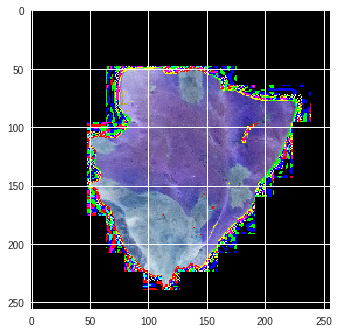

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
yhat=model2.predict(image)

disease_dict={'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5,
 'Tomato___healthy': 6}

list(disease_dict.keys())[np.argmax(yhat[0])]


'Tomato___Early_blight'

In [0]:
#yhat=model2.predict(image)
model2.predict(image)
#y_classes = keras.np_utils.probas_to_classes(y_proba)
#y_classes

array([[1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:

train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


generator = train_datagen.flow_from_directory("train", batch_size=batch_size)
generator.classes

Found 8159 images belonging to 7 classes.


array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [0]:
generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5,
 'Tomato___healthy': 6}

In [0]:
validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
    shuffle = "false",
class_mode = "categorical")

Found 2312 images belonging to 7 classes.


In [0]:
validation_generator.n / 8

289.0

In [0]:
Y_pred = model2.predict_generator(validation_generator, validation_generator.n // 32+1)

In [0]:
Y_pred.shape
len(validation_generator.classes)

2312

In [0]:
y_pred =np.argmax(Y_pred, axis=1)


In [0]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight','Tomato___Leaf_Mold','Tomato___Septoria_leaf_spot','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___healthy']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

[[ 46  21  48  17  38 111  39]
 [ 34  14  30   8  17  80  17]
 [ 40  26  72  18  35 124  35]
 [ 17  10  23   6  12  60  14]
 [ 27   7  24  10  21  54  17]
 [ 97  63 167  44  86 335  98]
 [ 31  17  53   9  24  93  23]]
Classification Report
                                        precision    recall  f1-score   support

               Tomato___Bacterial_spot       0.16      0.14      0.15       320
                 Tomato___Early_blight       0.09      0.07      0.08       200
                  Tomato___Late_blight       0.17      0.21      0.19       350
                    Tomato___Leaf_Mold       0.05      0.04      0.05       142
           Tomato___Septoria_leaf_spot       0.09      0.13      0.11       160
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.39      0.38      0.38       890
                      Tomato___healthy       0.09      0.09      0.09       250

                             micro avg       0.22      0.22      0.22      2312
                             macro avg